In [1]:
import importlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import  InputLayer, Conv2D, Lambda, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import os
import numpy as np
from PIL import Image

import Helper_Build_UNet_Model
import Helper_Create_Postprocessing_Model
import Helper_Calc_Mean_Alias_Value_Of_One_Image 

importlib.reload(Helper_Build_UNet_Model)
importlib.reload(Helper_Create_Postprocessing_Model)
importlib.reload(Helper_Calc_Mean_Alias_Value_Of_One_Image)

from Helper_Build_UNet_Model import build_unet_model
from Helper_Create_Postprocessing_Model import create_postprocessing_model, tf_inv_fourier_trans
from Helper_Calc_Mean_Alias_Value_Of_One_Image import calc_mean_alias_value_of_one_image

from tqdm import tqdm

import matplotlib.pyplot as plt

from UNet_Fourier_Facilities import Fourier_Images

import time


In [2]:
model_cnn = tf.keras.models.load_model("./cnn_models/single_rgb_image_regression_V02_epochs_100_1653595623")


In [3]:
np.random.seed = 42
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3


## Load Images

In [4]:
TRAIN_FILMED_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\filmed"
TRAIN_CLEAN_PATH = "D:\\Main\\MA_PROGR\\Data\\Train\\UNet_Train\\model_at_tree_100_pics\\clean_aligned"
# TEST_PATH = "./Data/data-science-bowl-2018/stage1_test/"


In [5]:
train_filmed_imgs = []
train_clean_imgs = []

In [6]:
OFFSET = 200
abbruch_idx = 30


def my_train_filmed_gen():
    for i, addr_filmed in enumerate(os.listdir(TRAIN_FILMED_PATH)):
        img =  plt.imread(f"{TRAIN_FILMED_PATH}\{addr_filmed}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]

def my_train_clean_gen():
    for i, addr_clean in enumerate(os.listdir(TRAIN_CLEAN_PATH)):
        img =  plt.imread(f"{TRAIN_CLEAN_PATH}\{addr_clean}")
        yield img[OFFSET:IMG_WIDTH+OFFSET, OFFSET:IMG_HEIGHT+OFFSET, :3]


train_filmed_img_gen_obj = my_train_filmed_gen()
train_clean_img_gen_obj = my_train_clean_gen()

## Build U-Net-Model

In [7]:
model_u_net = build_unet_model(IMG_WIDTH, IMG_HEIGHT)
# model_u_net.summary()


# Build Postprecessing Model

In [8]:
# postprocessing_model = create_postprocessing_model()
# postprocessing_model.summary()


## Custom Train loop


In [9]:
# Custom train loop

SAFE_RESULTS = True
WRITE_PATH = "D:\\Main\\MA_PROGR\\Data\\UNET_Output\\Session14"

show_intermediate_pics = False

RGB_WEIGHTS = [0.299, 0.587, 0.114]


overall_train_loss = []

execute_UNet_model = tf.function(model_u_net)
execute_cnn_model = tf.function(model_cnn)
# execute_postprocessing_model = tf.function(postprocessing_model)

NUM_EPOCHS = 20
batch_size_cnn = 1
batch_size_unet = 5


optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanAbsoluteError()
epoch_loss = tf.keras.metrics.MeanAbsoluteError()


train_writer = tf.summary.create_file_writer("u_net_logs/train/")
test_writer = tf.summary.create_file_writer("u_net_logs/test/")

y_true = tf.constant(0, dtype=tf.float16, name="y_true")

jump_to_new_epoch = False

for epoch in range(NUM_EPOCHS):

    print(f"Start of epoch {epoch}")
    jump_to_new_epoch = False

    # Mache neue Generater, sodass wieder durch alle Bilder durchgegange wird für die nächste Epoche:
    train_filmed_img_gen_obj = my_train_filmed_gen()
    train_clean_img_gen_obj = my_train_clean_gen()

    # ---------------------------------------------------------------------------- BATCHES SAMMELN Start ----------------------------------------------------------------------------------------
    train_step = 0

    for batch_idx in tqdm(range(batch_size_unet), desc="training...", ascii=False, ncols=75):
        print("next batch...")
        cnn_mean_prediction_values = []

        with tf.GradientTape() as tape:

            # Bilder für den nächsten Batch sammeln:
            for i in range(batch_size_unet):
                try:
                    x_filmed = train_filmed_img_gen_obj.__next__()
                    x_clean = train_clean_img_gen_obj.__next__()
                except StopIteration as e:
                    print(
                        "------------------------Am Ende angelangt, gehe in neue Epoche")

                    jump_to_new_epoch = True

                if jump_to_new_epoch == True:
                    # Alle Bilder sind aufgebraucht, gehe in neue Epoche
                    break

                y_pred, differenzbild_fourier_px, u_net_output, image_processed_rgb = calc_mean_alias_value_of_one_image(
                    x_filmed,
                    x_clean,
                    show_intermediate_pics,
                    IMG_WIDTH,
                    IMG_HEIGHT,
                    execute_cnn_model,
                    execute_UNet_model
                )
                cnn_mean_prediction_values.append(y_pred)

                # print("y_pred: ")
                # print(y_pred)

                # ---------------------------------------------------------------------------- BATCHES SAMMELN ENDE ----------------------------------------------------------------------------------------


            if SAFE_RESULTS:
                plt.imsave(
                    f"{WRITE_PATH}\\x_filmed_{epoch}_{batch_idx}.png", x_filmed)
                plt.imsave(
                    f"{WRITE_PATH}\\x_clean_{epoch}_{batch_idx}.png", x_clean)

                plt.imsave(f"{WRITE_PATH}\\differenzbild_{epoch}_{batch_idx}.png",
                           differenzbild_fourier_px.reshape((IMG_WIDTH, IMG_HEIGHT)), cmap="gray")



                u_net_output_for_img_save = np.array(u_net_output).reshape(IMG_WIDTH, IMG_HEIGHT)
                print("---------------> u_net_output_for_img_save")
                print(u_net_output_for_img_save)
                plt.imsave(f"{WRITE_PATH}\\unet_output_{epoch}_{batch_idx}.png",
                           u_net_output_for_img_save, cmap="gray")

                # image_processed_rgb umformen in Numpy-Array
                image_processed_rgb_for_img_save = np.array(
                    image_processed_rgb).reshape((IMG_WIDTH, IMG_HEIGHT, 3))
                try:
                    plt.imsave(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.png", image_processed_rgb_for_img_save)
                except ValueError:
                    print("------------------------- Speichern hat nicht geklappt, speichere stattdessen numpy array zur Inspektion:")
                    np.save(f"{WRITE_PATH}\\image_processed_rgb_{epoch}_{batch_idx}.npy", image_processed_rgb_for_img_save)


            if jump_to_new_epoch == True:
                # Alle Bilder sind aufgebraucht, gehe in neue epoche
                break

            # ----------- Calc loss for one batch -----------

            y_true = tf.zeros(batch_size_unet, 1)

            # print("cnn_mean_prediction_values.shape: ")
            # print(np.array(cnn_mean_prediction_values).shape)

            loss = loss_fn(y_true=y_true, y_pred=cnn_mean_prediction_values)
            # print("loss for one batch: ")
            # print(loss)

            gradients = tape.gradient(loss, model_u_net.trainable_weights)
            del cnn_mean_prediction_values[:]
            # print("gradients: ")
            # print(gradients)

            # Optimize the model:
            optimizer.apply_gradients(
                zip(gradients, model_u_net.trainable_variables))

            tmp = epoch_loss.update_state(y_true, y_pred)

            # print("tmp")
            # print(tmp)

            # print("------------------------------------")
            # print("y_true:")
            # print(y_true)

            # print("y_pred")
            # print(y_pred)
            # print("------------------------------------")

            # with train_writer.as_default():
            #     tf.summary.scalar("Loss", loss, step=train_step)
            #     tf.summary.scalar(
            #         "Accuracy", epoch_loss.result(), step=train_step,
            #     )
            # train_step += 1

        # End Epoch

        print(f"--------------- epoch_loss: {epoch_loss.result()}")
        overall_train_loss.append(epoch_loss.result())


# overall_train_loss = epoch_loss.result()
# print(f"overall_train_loss: {overall_train_loss}")
# epoch_loss.reset_states()




Start of epoch 0


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.49998754 0.49997696 0.4999778  ... 0.49999025 0.49998945 0.4999697 ]
 [0.49993926 0.499946   0.4998666  ... 0.49996275 0.4999637  0.49998716]
 [0.49999335 0.49996752 0.4999729  ... 0.49996242 0.4999487  0.49996847]
 ...
 [0.49985778 0.4999948  0.49988508 ... 0.4999876  0.49986678 0.49993053]
 [0.49997097 0.49996492 0.49990332 ... 0.49996743 0.4999314  0.499935  ]
 [0.4999102  0.49999908 0.49993876 ... 0.50001216 0.49997953 0.49994743]]


training...:  20%|█████▍                     | 1/5 [00:08<00:35,  8.99s/it]

--------------- epoch_loss: 0.10783790051937103
next batch...
---------------> u_net_output_for_img_save
[[0.5005635  0.50030583 0.5003933  ... 0.50041175 0.5001713  0.50013846]
 [0.5006196  0.50036997 0.50020915 ... 0.50007665 0.5003035  0.49982578]
 [0.5005379  0.50037295 0.500074   ... 0.50047505 0.5001929  0.5003074 ]
 ...
 [0.50054497 0.5003545  0.50042    ... 0.50004417 0.5001428  0.5000904 ]
 [0.5005709  0.5002443  0.500429   ... 0.5005369  0.50007117 0.5003244 ]
 [0.50032413 0.5004058  0.5001973  ... 0.50031483 0.5004189  0.50007546]]


training...:  40%|██████████▊                | 2/5 [00:14<00:20,  6.84s/it]

--------------- epoch_loss: 0.1201825961470604
next batch...
---------------> u_net_output_for_img_save
[[0.5014362  0.50115013 0.5011169  ... 0.5013065  0.5007254  0.50043756]
 [0.50166    0.501473   0.50158274 ... 0.50104994 0.5004392  0.500579  ]
 [0.50132406 0.50159657 0.5014286  ... 0.5014494  0.50130457 0.50038487]
 ...
 [0.5020489  0.50136656 0.5017545  ... 0.50094163 0.501306   0.5003863 ]
 [0.5014123  0.50173444 0.50181514 ... 0.5015054  0.50159675 0.5006048 ]
 [0.50091094 0.50076187 0.50104755 ... 0.50111145 0.50115484 0.5009377 ]]


training...:  60%|████████████████▏          | 3/5 [00:19<00:12,  6.05s/it]

--------------- epoch_loss: 0.12200954556465149
next batch...
---------------> u_net_output_for_img_save
[[0.5021367  0.501606   0.50159657 ... 0.50172436 0.5014735  0.5010484 ]
 [0.5027987  0.502427   0.50286657 ... 0.5025675  0.50163066 0.50108784]
 [0.5023975  0.50268185 0.5022882  ... 0.5030126  0.5026632  0.50139296]
 ...
 [0.50216925 0.5019937  0.5032467  ... 0.5029483  0.50234014 0.50074583]
 [0.502105   0.50303984 0.50295436 ... 0.50326633 0.50308377 0.5017668 ]
 [0.50172246 0.50108755 0.50168777 ... 0.5014587  0.5018624  0.5015197 ]]


training...:  80%|█████████████████████▌     | 4/5 [00:25<00:05,  5.87s/it]

--------------- epoch_loss: 0.11202221363782883
next batch...
---------------> u_net_output_for_img_save
[[0.5022846  0.5029341  0.5031882  ... 0.50295687 0.5025199  0.50159466]
 [0.5037137  0.5034085  0.5032114  ... 0.50371176 0.5034557  0.5011359 ]
 [0.50373435 0.5040319  0.50462484 ... 0.503832   0.50289    0.5024834 ]
 ...
 [0.5035299  0.50326025 0.5040963  ... 0.5045346  0.50397015 0.5017947 ]
 [0.5034336  0.503971   0.5043945  ... 0.5040202  0.50390667 0.5022007 ]
 [0.5019907  0.50362974 0.5022533  ... 0.50306195 0.50357115 0.5023344 ]]


training...: 100%|███████████████████████████| 5/5 [00:30<00:00,  6.05s/it]


--------------- epoch_loss: 0.10756723582744598
Start of epoch 1


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.5032588  0.50363255 0.5035138  ... 0.50359213 0.50244343 0.5010536 ]
 [0.50492555 0.5048481  0.5050355  ... 0.50451624 0.5049243  0.50137156]
 [0.50382483 0.5064617  0.5048692  ... 0.50464207 0.50534236 0.50229216]
 ...
 [0.50429755 0.50522774 0.50522    ... 0.50560284 0.50442255 0.5016916 ]
 [0.5043967  0.50605524 0.50547737 ... 0.5045444  0.5055322  0.5036513 ]
 [0.50268966 0.5040204  0.5047818  ... 0.5048587  0.5034441  0.50275755]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.57s/it]

--------------- epoch_loss: 0.10947980731725693
next batch...
---------------> u_net_output_for_img_save
[[0.50420684 0.50454134 0.5041293  ... 0.50525004 0.5037831  0.5021751 ]
 [0.50586414 0.50616455 0.5058695  ... 0.5059517  0.5057811  0.5027809 ]
 [0.5054093  0.5077457  0.504124   ... 0.5058228  0.5058386  0.50376093]
 ...
 [0.5061666  0.5058873  0.50740445 ... 0.5082082  0.50472265 0.50359464]
 [0.5051614  0.50734305 0.5066572  ... 0.5064722  0.50570786 0.5042315 ]
 [0.50352365 0.505708   0.5052907  ... 0.50419897 0.5054977  0.5040527 ]]


training...:  40%|██████████▊                | 2/5 [00:09<00:13,  4.58s/it]

--------------- epoch_loss: 0.10955941677093506
next batch...
---------------> u_net_output_for_img_save
[[0.5048325  0.50574136 0.5033517  ... 0.5060395  0.5045088  0.50159425]
 [0.507464   0.50707865 0.50756216 ... 0.5085022  0.50711733 0.5029195 ]
 [0.50349873 0.50841314 0.5108696  ... 0.51004946 0.5084413  0.50558627]
 ...
 [0.5080159  0.5067406  0.50804067 ... 0.5075965  0.50890774 0.50405717]
 [0.5056773  0.5083886  0.5088622  ... 0.509502   0.50875115 0.504594  ]
 [0.504007   0.50517195 0.50687283 ... 0.5062177  0.5059367  0.50382   ]]


training...:  60%|████████████████▏          | 3/5 [00:13<00:09,  4.59s/it]

--------------- epoch_loss: 0.11740749329328537
next batch...
---------------> u_net_output_for_img_save
[[0.5059961  0.506743   0.504596   ... 0.5073524  0.5048286  0.5023284 ]
 [0.5095917  0.50935036 0.50758034 ... 0.50852454 0.50876933 0.50434977]
 [0.507335   0.5115786  0.5109713  ... 0.51067704 0.51142997 0.50652385]
 ...
 [0.5093498  0.50750774 0.5094689  ... 0.51042974 0.51041514 0.50462973]
 [0.50730115 0.51206535 0.5114313  ... 0.51121175 0.5100758  0.5074817 ]
 [0.50572616 0.50804913 0.5075215  ... 0.5064263  0.5101917  0.505252  ]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.63s/it]

--------------- epoch_loss: 0.11981982737779617
next batch...
---------------> u_net_output_for_img_save
[[0.50537497 0.50959635 0.5058274  ... 0.5085282  0.50549793 0.50392616]
 [0.5110294  0.51180565 0.5109334  ... 0.5080753  0.51250225 0.50548935]
 [0.5085106  0.5139738  0.5133293  ... 0.5117142  0.51308227 0.5074175 ]
 ...
 [0.51066893 0.5116211  0.51022863 ... 0.5105528  0.51284355 0.50222576]
 [0.5077875  0.51325184 0.5085744  ... 0.51362324 0.5098226  0.50244087]
 [0.50703776 0.50842303 0.51058596 ... 0.50991803 0.50951356 0.5070757 ]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.62s/it]


--------------- epoch_loss: 0.11840846389532089
Start of epoch 2


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.5074793  0.50916046 0.50798184 ... 0.5104144  0.50736636 0.50281626]
 [0.5134244  0.5090948  0.51379097 ... 0.51522046 0.51336074 0.50651795]
 [0.5087255  0.51464474 0.5172509  ... 0.5165651  0.51587605 0.5083574 ]
 ...
 [0.5155589  0.5113688  0.51372993 ... 0.51319665 0.51373124 0.5076939 ]
 [0.509904   0.5180355  0.5151321  ... 0.5148892  0.51384574 0.5103875 ]
 [0.50798357 0.5110831  0.5111464  ... 0.51004463 0.51119435 0.5044627 ]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.61s/it]

--------------- epoch_loss: 0.11999845504760742
next batch...
---------------> u_net_output_for_img_save
[[0.50610155 0.511766   0.509462   ... 0.509112   0.510312   0.505555  ]
 [0.5169035  0.51588804 0.5188516  ... 0.51239496 0.5170419  0.50352275]
 [0.50917184 0.5208649  0.51706594 ... 0.51873976 0.51696235 0.5074169 ]
 ...
 [0.5186269  0.5109461  0.5197005  ... 0.5170243  0.51754504 0.50873107]
 [0.5098429  0.517721   0.51366603 ... 0.51917195 0.5185891  0.5080489 ]
 [0.5102361  0.51175195 0.51130563 ... 0.514745   0.5141688  0.50782067]]


training...:  40%|██████████▊                | 2/5 [00:09<00:13,  4.60s/it]

--------------- epoch_loss: 0.11855185776948929
next batch...
---------------> u_net_output_for_img_save
[[0.5075699  0.51458776 0.51205057 ... 0.5100165  0.50925905 0.5051261 ]
 [0.52138156 0.51920986 0.5208014  ... 0.5171665  0.5185729  0.5052962 ]
 [0.5102463  0.5275575  0.5182926  ... 0.52701837 0.52178794 0.51166475]
 ...
 [0.5216513  0.5156494  0.519214   ... 0.5203285  0.51606405 0.50521755]
 [0.5091134  0.5207389  0.51728296 ... 0.5194988  0.5172292  0.5086772 ]
 [0.5124008  0.5100007  0.5138255  ... 0.51478577 0.5129635  0.5058379 ]]


training...:  60%|████████████████▏          | 3/5 [00:13<00:09,  4.61s/it]

--------------- epoch_loss: 0.11656241118907928
next batch...
---------------> u_net_output_for_img_save
[[0.503922   0.51642174 0.5103659  ... 0.5156775  0.50769    0.5034946 ]
 [0.52982944 0.5196468  0.52838933 ... 0.52009493 0.5170797  0.50716335]
 [0.5073621  0.53309196 0.51435673 ... 0.5144796  0.52133304 0.5122697 ]
 ...
 [0.53536886 0.5167251  0.5234729  ... 0.52372026 0.5222389  0.50795066]
 [0.5065869  0.52260107 0.52371997 ... 0.52799076 0.52099043 0.51059484]
 [0.51736885 0.5208042  0.51107615 ... 0.5191685  0.51370513 0.511983  ]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.61s/it]

--------------- epoch_loss: 0.1161799430847168
next batch...
---------------> u_net_output_for_img_save
[[0.5012162  0.52691704 0.5154635  ... 0.5168801  0.51090246 0.5032785 ]
 [0.5335782  0.5212029  0.5300433  ... 0.5273384  0.52862054 0.50717   ]
 [0.5097484  0.50737774 0.51790214 ... 0.52605224 0.5306146  0.5107271 ]
 ...
 [0.56148374 0.5185279  0.52138835 ... 0.5308047  0.526495   0.5079573 ]
 [0.506276   0.5312647  0.52082425 ... 0.5253225  0.5324109  0.5152539 ]
 [0.52123624 0.50865084 0.50934297 ... 0.5145725  0.5212177  0.51022804]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.63s/it]


--------------- epoch_loss: 0.11648335307836533
Start of epoch 3


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.50397545 0.52776134 0.5243823  ... 0.5134251  0.5052005  0.50086933]
 [0.57102996 0.5231463  0.5251494  ... 0.53509027 0.524743   0.50251335]
 [0.46762484 0.5552496  0.483068   ... 0.5298468  0.5275489  0.5106683 ]
 ...
 [0.6105774  0.5522043  0.52138996 ... 0.5378958  0.53188115 0.50241166]
 [0.48432055 0.5481522  0.5573506  ... 0.5382123  0.53405553 0.5152819 ]
 [0.5246396  0.49209952 0.5080317  ... 0.52364403 0.5254044  0.50819063]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.65s/it]

--------------- epoch_loss: 0.11479733139276505
next batch...
---------------> u_net_output_for_img_save
[[0.48660025 0.55621433 0.5809541  ... 0.51791626 0.5258611  0.49980444]
 [0.68715864 0.54550594 0.5209326  ... 0.53521776 0.5522     0.50400734]
 [0.34184694 0.59422666 0.40529922 ... 0.55510765 0.5450769  0.499608  ]
 ...
 [0.7842625  0.5797556  0.5210372  ... 0.5535773  0.5562966  0.49465477]
 [0.42756483 0.65640366 0.6415418  ... 0.5562955  0.5800976  0.51464474]
 [0.5635184  0.5071297  0.49584004 ... 0.5335496  0.54015625 0.49969646]]


training...:  40%|██████████▊                | 2/5 [00:09<00:13,  4.61s/it]

--------------- epoch_loss: 0.11133960634469986
next batch...
---------------> u_net_output_for_img_save
[[0.40792352 0.6116799  0.556769   ... 0.5140404  0.53251404 0.4692096 ]
 [0.9711709  0.7217404  0.6092948  ... 0.5449946  0.50790435 0.49538255]
 [0.25177538 0.59214556 0.25935358 ... 0.51915675 0.53245026 0.4719425 ]
 ...
 [0.934289   0.8184825  0.47719613 ... 0.56600827 0.5871154  0.4795812 ]
 [0.31550157 0.7665375  0.74842393 ... 0.6645893  0.62299144 0.51682466]
 [0.63055056 0.6818012  0.44054192 ... 0.54491615 0.53363466 0.48697135]]


training...:  60%|████████████████▏          | 3/5 [00:13<00:09,  4.62s/it]

--------------- epoch_loss: 0.10748247057199478
next batch...
---------------> u_net_output_for_img_save
[[0.26951748 0.9408318  0.7741098  ... 0.5969317  0.5999781  0.4210795 ]
 [0.99804485 0.97065216 0.9401511  ... 0.6688792  0.6635393  0.43333033]
 [0.12825847 0.9291592  0.28368637 ... 0.41183898 0.7736044  0.54279137]
 ...
 [0.99972653 0.99936235 0.82875705 ... 0.7856915  0.7255851  0.43862826]
 [0.7721064  0.9893843  0.9370079  ... 0.8032149  0.8082149  0.4868189 ]
 [0.9590378  0.91551435 0.4723596  ... 0.6427989  0.72410697 0.46179754]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.62s/it]

--------------- epoch_loss: 0.10246223956346512
next batch...
---------------> u_net_output_for_img_save
[[0.19663653 0.909005   0.9423107  ... 0.6003031  0.5475949  0.29443896]
 [1.         0.98054445 0.9452627  ... 0.92702115 0.73544365 0.3840956 ]
 [0.7399858  0.9898418  0.99566346 ... 0.8163825  0.94655263 0.2757604 ]
 ...
 [1.         1.         0.91871893 ... 0.6853099  0.44946018 0.39029527]
 [0.5211801  0.9996702  0.99985105 ... 0.9790255  0.8499248  0.4985697 ]
 [0.89934236 0.8818414  0.9456194  ... 0.79266155 0.75006354 0.46438047]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.63s/it]


--------------- epoch_loss: 0.09806348383426666
Start of epoch 4


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.00207776 0.99830425 0.99994826 ... 0.6606864  0.6143681  0.18893567]
 [1.         0.99999714 1.         ... 0.9427982  0.7481379  0.22205016]
 [0.10420859 1.         0.9966866  ... 0.6988405  0.94384784 0.6151403 ]
 ...
 [1.         1.         0.99760914 ... 0.92441213 0.98996425 0.18948144]
 [0.98967427 1.         0.9999995  ... 0.9996501  0.9856301  0.58576035]
 [0.9999974  0.999998   0.5051666  ... 0.97429943 0.989565   0.3315264 ]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.63s/it]

--------------- epoch_loss: 0.09496217221021652
next batch...
---------------> u_net_output_for_img_save
[[6.7988336e-03 9.9973691e-01 9.9591339e-01 ... 7.6125044e-01
  8.1563473e-01 1.6416642e-01]
 [1.0000000e+00 9.9999809e-01 1.0000000e+00 ... 9.9920440e-01
  9.9387693e-01 6.5697223e-02]
 [9.6820319e-01 1.0000000e+00 9.4684792e-01 ... 9.5381796e-01
  9.9875247e-01 2.1592447e-01]
 ...
 [1.0000000e+00 1.0000000e+00 1.6644467e-06 ... 9.9940169e-01
  9.9412364e-01 4.8494047e-01]
 [9.3832713e-01 1.0000000e+00 1.0000000e+00 ... 9.9205786e-01
  9.8824322e-01 3.6223525e-01]
 [1.0000000e+00 1.0000000e+00 9.9615085e-01 ... 9.9307120e-01
  9.9811149e-01 5.0509524e-01]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.67s/it]

--------------- epoch_loss: 0.09129653126001358
next batch...
---------------> u_net_output_for_img_save
[[2.7043025e-12 9.9999964e-01 1.0000000e+00 ... 7.4984002e-01
  9.1730613e-01 1.2130499e-02]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9911165e-01
  9.9949324e-01 3.8169205e-02]
 [9.9999142e-01 1.0000000e+00 1.0000000e+00 ... 9.9925351e-01
  1.0000000e+00 8.6437255e-02]
 ...
 [1.0000000e+00 1.0000000e+00 9.9999797e-01 ... 9.9989343e-01
  9.9995434e-01 1.7152742e-01]
 [9.9998856e-01 1.0000000e+00 1.0000000e+00 ... 9.9998510e-01
  9.9956739e-01 4.9829990e-01]
 [1.0000000e+00 7.9888999e-03 9.9999976e-01 ... 9.8967493e-01
  9.9987662e-01 6.6728294e-01]]


training...:  60%|████████████████▏          | 3/5 [00:13<00:09,  4.66s/it]

--------------- epoch_loss: 0.0880352184176445
next batch...
---------------> u_net_output_for_img_save
[[3.4675257e-10 3.2517827e-01 1.0000000e+00 ... 9.9791956e-01
  9.9174714e-01 3.0356646e-04]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0539987e-04]
 [3.7281379e-14 1.0000000e+00 1.0000000e+00 ... 9.9996960e-01
  1.0000000e+00 3.1926692e-02]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999768e-01
  9.9998355e-01 4.3882817e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999613e-01
  9.9999225e-01 3.3114630e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9914974e-01
  9.9756539e-01 7.7833939e-01]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.68s/it]

--------------- epoch_loss: 0.084942527115345
next batch...
---------------> u_net_output_for_img_save
[[1.0352496e-20 1.0000000e+00 1.0000000e+00 ... 9.9970877e-01
  9.9688268e-01 1.3703108e-04]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0545254e-03]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999946e-01
  1.0000000e+00 4.3567121e-03]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.7258018e-02]
 [9.9999619e-01 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.1331800e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999887e-01
  1.0000000e+00 4.5722157e-02]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


--------------- epoch_loss: 0.0820474922657013
Start of epoch 5


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 2.2860330e-01
  9.9983943e-01 4.3613722e-06]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.2870762e-05]
 [1.4796853e-04 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.4366379e-04]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.8126494e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.0587118e-02]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999952e-01
  1.0000000e+00 7.8971779e-01]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.68s/it]

--------------- epoch_loss: 0.07945211976766586
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999440e-01
  9.9338233e-01 2.0227955e-09]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.2220612e-04]
 [0.0000000e+00 1.0000000e+00 2.7555775e-28 ... 2.1475328e-09
  1.0000000e+00 3.2962802e-08]
 ...
 [1.0000000e+00 1.0000000e+00 8.3378762e-02 ... 1.0000000e+00
  1.0000000e+00 2.6714206e-03]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.5456309e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.3538688e-01]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.68s/it]

--------------- epoch_loss: 0.07693751901388168
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9967003e-01
  9.9999845e-01 5.9163577e-12]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9999809e-01
  1.0000000e+00 2.9707627e-09]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.3952603e-10]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  9.9920952e-01 3.1033158e-04]
 [9.8111689e-01 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 8.1335425e-02]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 6.3426793e-03]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.68s/it]

--------------- epoch_loss: 0.0747578963637352
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9974120e-01
  1.2068152e-03 1.4850064e-17]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9998969e-01
  1.0000000e+00 5.5358783e-15]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 3.2788763e-21]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.0796061e-04]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.8209984e-03]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.6472638e-03]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.70s/it]

--------------- epoch_loss: 0.07259032875299454
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.4224918e-01
  1.0000000e+00 5.9040352e-20]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 7.6711565e-16]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 7.9703136e-07
  1.0000000e+00 6.4751338e-23]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  9.9999535e-01 1.3023811e-08]
 [2.1336341e-17 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  9.3059230e-01 6.8099858e-08]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.7602549e-05]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.69s/it]


--------------- epoch_loss: 0.07067345082759857
Start of epoch 6


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 4.4944295e-01
  9.9999356e-01 6.5260713e-22]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.3080554e-24]
 [0.0000000e+00 1.0000000e+00 1.1668724e-12 ... 1.0000000e+00
  1.0000000e+00 1.1446915e-31]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.1565541e-11]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  2.1254876e-01 7.1842074e-03]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.9529180e-08]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.71s/it]

--------------- epoch_loss: 0.06869238615036011
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  5.0835657e-01 2.6772511e-38]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.5223818e-33]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.5979730e-20
  1.0000000e+00 2.7590459e-30]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.0220659e-10]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.9868719e-08]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 7.4891447e-11]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.71s/it]

--------------- epoch_loss: 0.06721575558185577
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 8.8002172e-33
  9.9999988e-01 1.3212791e-27]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 7.1556309e-07
  1.0000000e+00 1.1138582e-23]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.6501430e-08
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.7736672e-11]
 [8.3143080e-36 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.2901742e-07]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 8.1832275e-12]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.71s/it]

--------------- epoch_loss: 0.06569080054759979
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 3.8953626e-08]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 4.9721132e-20
  1.0000000e+00 2.9234126e-27]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.4506193e-35]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.4177647e-14]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.0087216e-06]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.2480978e-11]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.71s/it]

--------------- epoch_loss: 0.0640646442770958
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.1015368e-06
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.0127019e-16]
 [7.4576980e-30 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 3.5499570e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.0405993e-19]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


--------------- epoch_loss: 0.06281249970197678
Start of epoch 7


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.4363600e-01
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 7.2330086e-11]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.3518538e-19]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 8.8433014e-31]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.69s/it]

--------------- epoch_loss: 0.061573609709739685
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 4.7460165e-35]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.1638887e-01
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.8217832e-18]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.9003338e-06]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 6.3180266e-22]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.69s/it]

--------------- epoch_loss: 0.06028319150209427
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 9.0940071e-36]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 9.9966192e-01
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.7942713e-25]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.6315017e-18]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.9083894e-18]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.70s/it]

--------------- epoch_loss: 0.059417083859443665
next batch...
---------------> u_net_output_for_img_save
[[0.00000000e+00 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 1.32019561e-20]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 6.09906147e-06
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 5.81929266e-01
  1.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 1.11023895e-13 ... 1.00000000e+00
  1.00000000e+00 5.19423542e-21]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00435205e-27]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.72s/it]

--------------- epoch_loss: 0.05816980451345444
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.5371442e-03
  1.0000000e+00 5.5031840e-36]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.9912751e-01]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.9303466e-30]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


--------------- epoch_loss: 0.05739995092153549
Start of epoch 8


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 5.6969674e-13
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 3.3314547e-19
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.6465594e-27]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.3375206e-07]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 6.1436937e-22]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.72s/it]

--------------- epoch_loss: 0.056542884558439255
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0350074e-30]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 2.7531260e-38]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 5.3936790e-20
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 8.2422996e-23]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.69s/it]

--------------- epoch_loss: 0.055582620203495026
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 2.4204029e-30]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0652255e-04]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.68s/it]

--------------- epoch_loss: 0.05495072901248932
next batch...
---------------> u_net_output_for_img_save
[[0.         1.         1.         ... 1.         1.         0.        ]
 [1.         1.         1.         ... 1.         1.         0.        ]
 [0.         1.         0.         ... 0.         1.         0.        ]
 ...
 [1.         1.         1.         ... 1.         1.         0.        ]
 [0.         1.         0.99999726 ... 1.         1.         0.        ]
 [1.         1.         1.         ... 1.         1.         0.        ]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.69s/it]

--------------- epoch_loss: 0.05414116382598877
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 2.2071111e-20
  1.0000000e+00 9.3043799e-35]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.8724488e-22]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.69s/it]


--------------- epoch_loss: 0.05361560732126236
Start of epoch 9


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.000000e+00 0.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  8.960680e-08]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00 ... 1.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 0.000000e+00 ... 1.000000e+00 1.000000e+00
  5.378423e-24]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.75s/it]

--------------- epoch_loss: 0.0530267171561718
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 8.2217706e-21]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.99s/it]

--------------- epoch_loss: 0.05288888141512871
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 5.1185294e-35]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0736515e-27]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.89s/it]

--------------- epoch_loss: 0.052242133766412735
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 2.2651033e-13
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.3492703e-03
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 1.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.3290992e-20
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.7934521e-12]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.81s/it]

--------------- epoch_loss: 0.05157811939716339
next batch...
---------------> u_net_output_for_img_save
[[0.000000e+00 1.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 7.204185e-07 1.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 1.000000e+00 ... 0.000000e+00 1.000000e+00
  0.000000e+00]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.82s/it]


--------------- epoch_loss: 0.05122113227844238
Start of epoch 10


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 0. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.68s/it]

--------------- epoch_loss: 0.05057285353541374
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.74s/it]

--------------- epoch_loss: 0.05031019449234009
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.8658748e-22
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.72s/it]

--------------- epoch_loss: 0.049874093383550644
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.4095178e-04]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.74s/it]

--------------- epoch_loss: 0.04949839413166046
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.73s/it]


--------------- epoch_loss: 0.048884663730859756
Start of epoch 11


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.93s/it]

--------------- epoch_loss: 0.04853896424174309
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.76s/it]

--------------- epoch_loss: 0.0483529195189476
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.74s/it]

--------------- epoch_loss: 0.04791579395532608
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.76s/it]

--------------- epoch_loss: 0.04733247682452202
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.82s/it]


--------------- epoch_loss: 0.04685739427804947
Start of epoch 12


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.68s/it]

--------------- epoch_loss: 0.046547189354896545
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  2.0427718e-34 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.73s/it]

--------------- epoch_loss: 0.04621158912777901
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 4.1961672e-34]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.73s/it]

--------------- epoch_loss: 0.045832280069589615
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.92s/it]

--------------- epoch_loss: 0.04534299299120903
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.90s/it]


--------------- epoch_loss: 0.045104049146175385
Start of epoch 13


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.81s/it]

--------------- epoch_loss: 0.04478048160672188
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.76s/it]

--------------- epoch_loss: 0.04462829604744911
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.76s/it]

--------------- epoch_loss: 0.044222813099622726
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.76s/it]

--------------- epoch_loss: 0.04378928244113922
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.5161584e-15]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.77s/it]


--------------- epoch_loss: 0.043423522263765335
Start of epoch 14


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.73s/it]

--------------- epoch_loss: 0.04301014915108681
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.73s/it]

--------------- epoch_loss: 0.04274331033229828
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.72s/it]

--------------- epoch_loss: 0.042462367564439774
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.71s/it]

--------------- epoch_loss: 0.04198543727397919
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.72s/it]


--------------- epoch_loss: 0.04172319918870926
Start of epoch 15


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.68s/it]

--------------- epoch_loss: 0.04155557230114937
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.72s/it]

--------------- epoch_loss: 0.041249632835388184
next batch...
---------------> u_net_output_for_img_save
[[0.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 ...
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  0.000000e+00]
 [0.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  1.000000e+00]
 [1.000000e+00 1.000000e+00 1.000000e+00 ... 1.000000e+00 1.000000e+00
  5.007221e-24]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.75s/it]

--------------- epoch_loss: 0.04088795930147171
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.70s/it]

--------------- epoch_loss: 0.040546514093875885
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.71s/it]


--------------- epoch_loss: 0.04023777320981026
Start of epoch 16


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 9.3281806e-11]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.63s/it]

--------------- epoch_loss: 0.040061451494693756
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.68s/it]

--------------- epoch_loss: 0.039840877056121826
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.4505033e-25]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.68s/it]

--------------- epoch_loss: 0.039519719779491425
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.70s/it]

--------------- epoch_loss: 0.039254602044820786
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.5012255e-07]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 5.1999674e-35]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.69s/it]


--------------- epoch_loss: 0.03894495591521263
Start of epoch 17


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.3037527e-31]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]]


training...:  20%|█████▍                     | 1/5 [00:04<00:19,  4.77s/it]

--------------- epoch_loss: 0.03878195211291313
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.4031924e-05]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.71s/it]

--------------- epoch_loss: 0.0385306142270565
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 3.2533764e-26]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.9742585e-05]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.71s/it]

--------------- epoch_loss: 0.038260072469711304
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.4331389e-15]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.72s/it]

--------------- epoch_loss: 0.03803760185837746
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.70s/it]


--------------- epoch_loss: 0.03780726343393326
Start of epoch 18


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.73s/it]

--------------- epoch_loss: 0.03764307498931885
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0194766e-05]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.69s/it]

--------------- epoch_loss: 0.03741457313299179
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.70s/it]

--------------- epoch_loss: 0.0371728241443634
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  80%|█████████████████████▌     | 4/5 [00:18<00:04,  4.68s/it]

--------------- epoch_loss: 0.036957647651433945
next batch...
---------------> u_net_output_for_img_save
[[0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 ...
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 1.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [1.0000000e+00 1.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  1.0000000e+00 2.8929476e-28]]


training...: 100%|███████████████████████████| 5/5 [00:23<00:00,  4.72s/it]


--------------- epoch_loss: 0.03674986585974693
Start of epoch 19


training...:   0%|                                   | 0/5 [00:00<?, ?it/s]

next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...:  20%|█████▍                     | 1/5 [00:04<00:18,  4.70s/it]

--------------- epoch_loss: 0.03662201762199402
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  40%|██████████▊                | 2/5 [00:09<00:14,  4.86s/it]

--------------- epoch_loss: 0.03643255680799484
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  60%|████████████████▏          | 3/5 [00:14<00:09,  4.91s/it]

--------------- epoch_loss: 0.03619038313627243
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]


training...:  80%|█████████████████████▌     | 4/5 [00:19<00:04,  4.89s/it]

--------------- epoch_loss: 0.036002300679683685
next batch...
---------------> u_net_output_for_img_save
[[0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [0. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 0.]]


training...: 100%|███████████████████████████| 5/5 [00:24<00:00,  4.85s/it]

--------------- epoch_loss: 0.035762637853622437


In [14]:
np.save(f"{WRITE_PATH}\\00_overall_train_loss.npy", overall_train_loss)

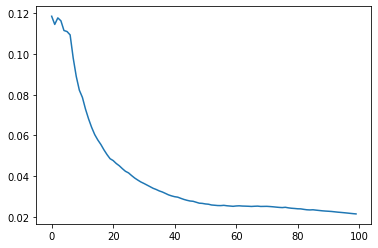

In [ ]:

plt.plot(overall_train_loss)

In [ ]:
len(np.array(overall_train_loss))


100

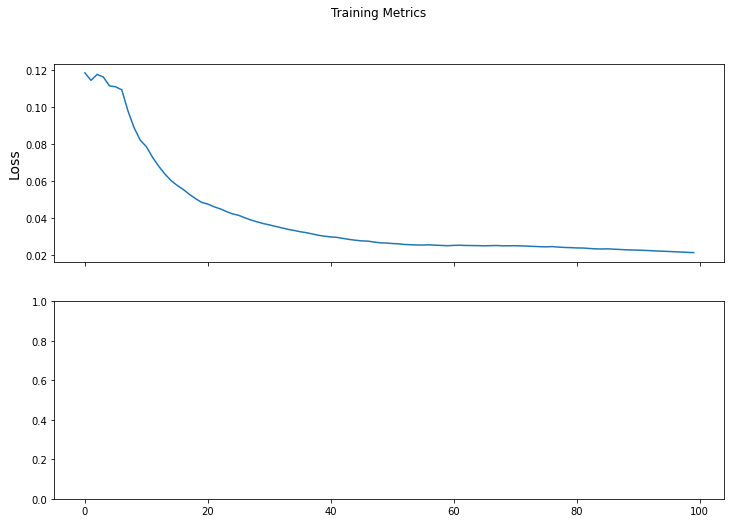

In [ ]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(overall_train_loss)

plt.show()


In [ ]:
# test_img = img[400:528, 400:528,:]
# test_img = np.array(test_img).reshape(1, 128 , 128 , 3)

# # plt.imshow(test_img)

# test_img= tf.convert_to_tensor(test_img, dtype=tf.float32)

# test_img


In [ ]:
# import tensorflow as tf
# BATCH_SIZE = 1
# NUM_BOXES = 3
# IMAGE_HEIGHT = 128
# IMAGE_WIDTH = 128
# CHANNELS = 3
# CROP_SIZE = (24, 24)

# test_img = img[400:528, 400:528, :]
# test_img = np.array(test_img).reshape(1, 128, 128, 3)

# # plt.imshow(test_img)

# test_img = tf.convert_to_tensor(test_img, dtype=tf.float32)
# image = test_img
# boxes = tf.random.uniform(shape=(NUM_BOXES, 4))
# # plt.imshow(np.array(image).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
# # plt.show()
# box_indices = tf.random.uniform(shape=(NUM_BOXES,), minval=0,
#                                 maxval=BATCH_SIZE, dtype=tf.int32)
# output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
# output.shape  # => (5, 24, 24, 3)

# plt.imshow(output[2])
